In [18]:
#This section links the notebook to the project root directory
import sys,os

nb_path = os.path.abspath('')
print("Current Path:", nb_path)

#get root working directory, link to notebook
PROJ_ROOT = os.path.abspath(os.path.join(nb_path,'..','..'))
print("Project Root:", PROJ_ROOT)
if PROJ_ROOT not in sys.path:
    sys.path.insert(0,PROJ_ROOT)

Current Path: /Users/saiganesh/Documents/MachineLearning/ECS171/project/project/models/mlp
Project Root: /Users/saiganesh/Documents/MachineLearning/ECS171/project/project


In [19]:
#Getting data, including preprocessing if necessary
from data_preprocess import preprocess
import os, numpy as np

#get directory, and X.npy and y.npy
raw_dir_training = os.path.join(PROJ_ROOT, "..", "archive", "seg_train", "seg_train")
raw_dir_test = os.path.join(PROJ_ROOT,"..","archive","seg_test","seg_test")
Xtrain_path,ytrain_path = 'Xtrain.npy','ytrain.npy'
Xtest_path,ytest_path = 'Xtest.npy','ytest.npy'
classes_path = "classes.npy"

#check if npy training files exist
#if files do not exist, they will be created
##NOTE: doing so will use ~4.5GB of data, so please make sure they are
## in the correct directory so they are not reproduced.
print("Checking if training files exist...")
if not os.path.exists(Xtrain_path) or not os.path.exists(ytrain_path):
    print("Not found, now preprocessing training imgs...")
    preprocess(
        input_dir=raw_dir_training,
        target_size=(150,150),
        out_X="Xtrain.npy",
        out_y="ytrain.npy"
    )
    print("Finished preprocessing training! (Finished files may be in root. Please move to mlp folder.)")
else:
     print("Training files found!")

#check if npy test files exist
print("Checking if test files exist...")
if not os.path.exists(Xtest_path) or not os.path.exists(ytest_path):
    print("Not found, now preprocessing test imgs...")
    preprocess(
        input_dir=raw_dir_test,
        target_size=(150,150),
        out_X="Xtest.npy",
        out_y="ytest.npy"
    )
    print("Finished preprocessing test! (Finished files may be in root. Please move to mlp folder.)")
else:
    print("Test files found!")

Checking if training files exist...
Training files found!
Checking if test files exist...
Test files found!


In [20]:
#check if npy test files exist
print("Checking if test files exist...")
if not os.path.exists(Xtest_path) or not os.path.exists(ytest_path):
    print("Not found, now preprocessing test imgs...")
    preprocess(
        input_dir=raw_dir_test,
        target_size=(150,150),
        out_X="Xtest.npy",
        out_y="ytest.npy"
    )
    print("Finished preprocessing test! (Finished files may be in root. Please move to mlp folder.)")
else:
    print("Test files found!")

# ──────────────────────────────────────────────────────────────────────────
# 2. **Load the canonical class list**  (NEW)
# ──────────────────────────────────────────────────────────────────────────
if not os.path.exists(classes_path):
    raise FileNotFoundError(
        "classes.npy not found. Make sure preprocess() saved it in this folder."
    )

classes = np.load(classes_path)      # ← single source of truth
n_classes = len(classes)
print("Loaded", n_classes, "class names from classes.npy")

Checking if test files exist...
Test files found!
Loaded 6 class names from classes.npy


In [23]:
#The interesting stuff, making the model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


#Load datasets from folder and print their shape
Xtrain,ytrain = np.load(Xtrain_path), np.load(ytrain_path)
print("X shape:", Xtrain.shape, "y shape:", ytrain.shape)

classes   = np.load("classes.npy")       # ← single source of truth
n_classes = len(classes)
print("n_classes:", n_classes)

#Defining the function for the modelab
#making the MLP, using ReLU then softmax

def make_mlp(width=1024, depth=4,           # width per layer, number of hidden layers
             lr=1e-3, dropout=0.3, l2=1e-4,
             input_dim=150*150*3,           # 67 500
             n_classes=n_classes):
    print("Building MLP")
    model = Sequential()

    # first (input) layer
    model.add(Dense(width, activation='relu',
                    kernel_regularizer=regularizers.l2(l2),
                    input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    # hidden layers
    for _ in range(depth - 1):
        model.add(Dense(width, activation='relu',
                        kernel_regularizer=regularizers.l2(l2)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    # compile
    model.compile(optimizer=Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

testModel = make_mlp()
testModel.summary()

X shape: (14034, 67500) y shape: (14034,)
n_classes: 6
Building MLP


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 1024)           │    69,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,292,358 (275.77 MB)

 Trainable params: 72,284,166 (275.74 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [27]:
#Here the model is tested with a smaller data set and tuned accordingly.
#Tuning had to be done by hand, as using GridSearchCV resulted in extremely long
#processing time and memory usage.
#Tuning by hand, with verbose on, allows for trackable progress.
#First, we halve our data to speed up tuning time

import numpy as np, os, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             accuracy_score,
                             classification_report)
from tensorflow.keras.callbacks import EarlyStopping

classes = np.load("classes.npy")       # single source of truth
n_classes = len(classes)

# Stratified 80/20 split for quick hyper-parameter tuning
X_tune, X_val, y_tune, y_val = train_test_split(
    Xtrain, ytrain,
    test_size=0.2,
    stratify=ytrain,
    random_state=42
)

print("Tune set :", X_tune.shape, " Val set :", X_val.shape)

print("X shape:",X_tune.shape,"y shape:",y_tune.shape)
print("X test shape:",X_tune_test.shape,"y test shape:",y_tune_test.shape)


Tune set : (11227, 67500)  Val set : (2807, 67500)
X shape: (11227, 67500) y shape: (11227,)
X test shape: (1500, 67500) y test shape: (1500,)


In [31]:
es = EarlyStopping(patience=3, restore_best_weights=True)


#Training model_1
#Model 1 is baseline, no changes made.
model_1 = make_mlp(width=256)
print("Fitting model_1...")
hist_model_1=model_1.fit(X_tune,y_tune,
                         epochs=15,
                         batch_size=128,
                         validation_data=(X_val,y_val),
                         callbacks=[es],
                         verbose=2
                        )

Building MLP
Fitting model_1...
Epoch 1/15
88/88 - 13s - 153ms/step - accuracy: 0.3832 - loss: 1.9083 - val_accuracy: 0.3865 - val_loss: 2.7334
Epoch 2/15
88/88 - 7s - 79ms/step - accuracy: 0.4368 - loss: 1.6768 - val_accuracy: 0.4874 - val_loss: 1.5878
Epoch 3/15
88/88 - 7s - 76ms/step - accuracy: 0.4560 - loss: 1.5667 - val_accuracy: 0.4553 - val_loss: 1.6130
Epoch 4/15
88/88 - 7s - 80ms/step - accuracy: 0.4674 - loss: 1.5227 - val_accuracy: 0.4670 - val_loss: 1.6599
Epoch 5/15
88/88 - 7s - 78ms/step - accuracy: 0.4758 - loss: 1.4898 - val_accuracy: 0.4418 - val_loss: 1.5620
Epoch 6/15
88/88 - 7s - 76ms/step - accuracy: 0.4823 - loss: 1.4801 - val_accuracy: 0.4642 - val_loss: 1.6046
Epoch 7/15
88/88 - 7s - 77ms/step - accuracy: 0.4816 - loss: 1.4657 - val_accuracy: 0.2152 - val_loss: 2.6369
Epoch 8/15
88/88 - 7s - 78ms/step - accuracy: 0.4929 - loss: 1.4617 - val_accuracy: 0.3801 - val_loss: 1.7045


In [34]:
#Training model_2
#A dropout rate of 0.1 is used
model_2 = make_mlp(width=256, dropout=0.1)
print("Fitting model_2...")
hist_model_2= model_2.fit(X_tune,y_tune,
                         epochs=15,
                         batch_size=128,
                         validation_data=(X_val,y_val),
                         callbacks=[es],
                        )

Building MLP
Fitting model_2...
Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.4140 - loss: 1.7965 - val_accuracy: 0.3057 - val_loss: 4.2590
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4926 - loss: 1.5162 - val_accuracy: 0.4425 - val_loss: 1.9845
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5099 - loss: 1.4511 - val_accuracy: 0.5148 - val_loss: 1.6098
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5215 - loss: 1.4274 - val_accuracy: 0.3897 - val_loss: 1.9498
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.5145 - loss: 1.4306 - val_accuracy: 0.4510 - val_loss: 1.5818
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5168 - loss: 1.4253 - val_accuracy: 0.3840 - val_loss: 1.9911
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5178 - loss: 1.4180 - val_accuracy: 0.3317 - val_loss: 1.9809
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5221 - loss:

In [35]:
#Training model_3
#A learning rate of 0.0001 is used
model_3 = make_mlp(width=256, lr=0.0001)
print("Fitting model_3...")
hist_model_3 = model_3.fit(X_tune,y_tune,
                         epochs=15,
                         batch_size=128,
                         validation_data=(X_val,y_val),
                         callbacks=[es],
                        )

Building MLP
Fitting model_3...
Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.3113 - loss: 2.2527 - val_accuracy: 0.3833 - val_loss: 2.2531
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4088 - loss: 1.8646 - val_accuracy: 0.4788 - val_loss: 1.6652
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.4322 - loss: 1.7459 - val_accuracy: 0.4952 - val_loss: 1.5917
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4405 - loss: 1.7081 - val_accuracy: 0.4168 - val_loss: 1.7977
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.4437 - loss: 1.6765 - val_accuracy: 0.4670 - val_loss: 1.5917
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.4489 - loss: 1.6254 - val_accuracy: 0.5055 - val_loss: 1.4730
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.4553 - loss: 1.6180 - val_accuracy: 0.4966 - val_loss: 1.4786
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4605 - loss:

In [36]:
#Combining model 2 and 3
#Uses a dropout rate of 0.1 and a learning rate of 0.0001
model_4 = make_mlp(width=256, dropout=0.1,lr=0.0001)
print("Fitting model_4...")
hist_model_4=model_4.fit(X_tune,y_tune,
                         epochs=15,
                         batch_size=128,
                         validation_data=(X_val,y_val),
                         callbacks=[es],
                         verbose=1
                        )

Building MLP
Fitting model_4...
Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.3938 - loss: 1.7984 - val_accuracy: 0.3951 - val_loss: 2.4999
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4730 - loss: 1.5453 - val_accuracy: 0.4874 - val_loss: 1.5709
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.4906 - loss: 1.4817 - val_accuracy: 0.4738 - val_loss: 1.6720
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.5067 - loss: 1.4432 - val_accuracy: 0.4638 - val_loss: 1.5609
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.5168 - loss: 1.4454 - val_accuracy: 0.5308 - val_loss: 1.4010
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.5187 - loss: 1.4230 - val_accuracy: 0.5362 - val_loss: 1.4005
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.5236 - loss: 1.4158 - val_accuracy: 0.4988 - val_loss: 1.4473
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.5277 - loss:

Model Loss Visualization


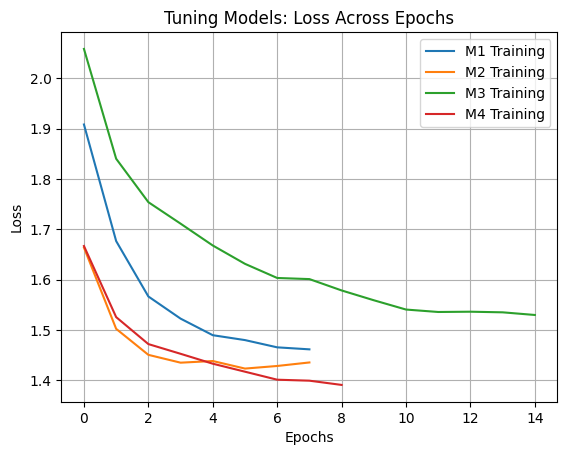

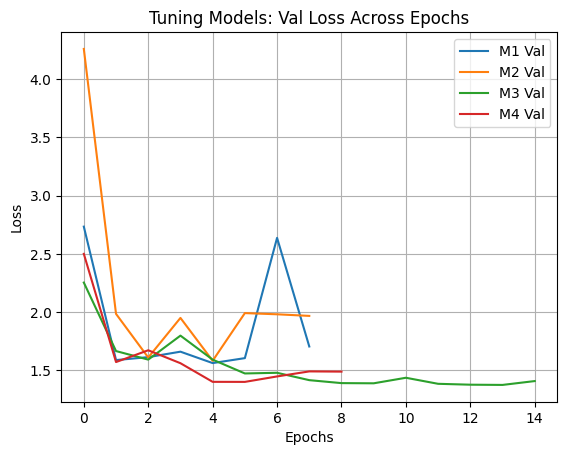

Model with consistently lower loss is model_4


In [37]:
import matplotlib.pyplot as plt

print("Model Loss Visualization")
plt.plot(hist_model_1.history['loss'], label='M1 Training')
plt.plot(hist_model_2.history['loss'], label='M2 Training')
plt.plot(hist_model_3.history['loss'], label='M3 Training')
plt.plot(hist_model_4.history['loss'], label='M4 Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_loss'],label='M1 Val')
plt.plot(hist_model_2.history['val_loss'],label='M2 Val')
plt.plot(hist_model_3.history['val_loss'],label='M3 Val')
plt.plot(hist_model_4.history['val_loss'],label='M4 Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with consistently lower loss is model_4")

Model Accuracy Visualization


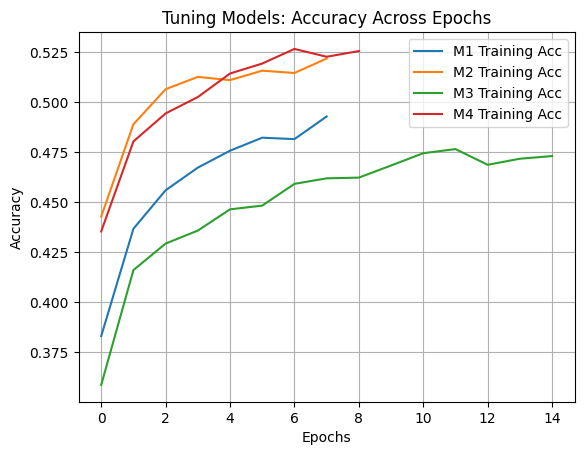

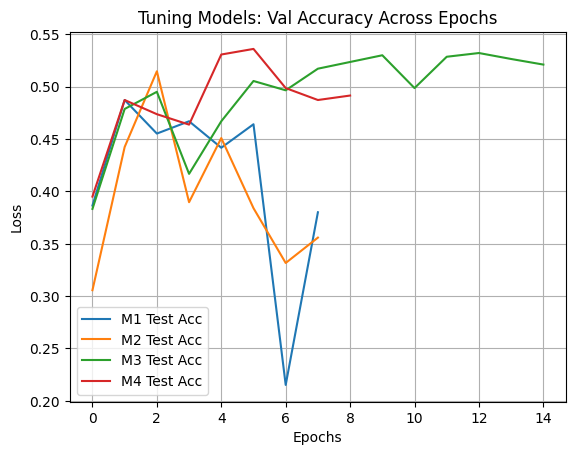

Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.


In [38]:
print("Model Accuracy Visualization")
plt.plot(hist_model_1.history['accuracy'], label='M1 Training Acc')
plt.plot(hist_model_2.history['accuracy'], label='M2 Training Acc')
plt.plot(hist_model_3.history['accuracy'], label='M3 Training Acc')
plt.plot(hist_model_4.history['accuracy'], label='M4 Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Tuning Models: Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_accuracy'],label='M1 Test Acc')
plt.plot(hist_model_2.history['val_accuracy'],label='M2 Test Acc')
plt.plot(hist_model_3.history['val_accuracy'],label='M3 Test Acc')
plt.plot(hist_model_4.history['val_accuracy'],label='M4 Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.")

In [41]:
#Training model_5
#Epoch size of 30 and batch size of 128
final_model = make_mlp(width=256, lr=1e-4, dropout=0.1)

es = EarlyStopping(patience=4, restore_best_weights=True)

print("Fitting final model...")
hist_final_model= final_model.fit(Xtrain,ytrain,
                                  epochs=30,
                                  batch_size=128,
                                  validation_split=0.1,
                                  callbacks=[es]
                                 ) #Final model is trained with more epochs and lower batch_size to allow more time for convergence, and lower memory load

final_model.save("best_mlp.h5")

Building MLP
Fitting final model...
Epoch 1/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.4191 - loss: 1.7832 - val_accuracy: 0.6959 - val_loss: 0.9611
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.4945 - loss: 1.5197 - val_accuracy: 0.5142 - val_loss: 1.2743
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4962 - loss: 1.4837 - val_accuracy: 0.7051 - val_loss: 0.8948
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5014 - loss: 1.4545 - val_accuracy: 0.7151 - val_loss: 0.9474
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5076 - loss: 1.4337 - val_accuracy: 0.5242 - val_loss: 1.3450
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5109 - loss: 1.4124 - val_accuracy: 0.6638 - val_loss: 1.0608
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5141 - loss: 1.4093 - val_accuracy: 0.5363 - val_loss: 1.4444


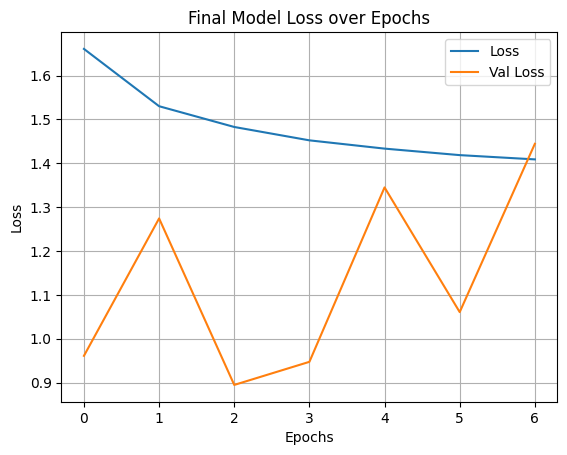

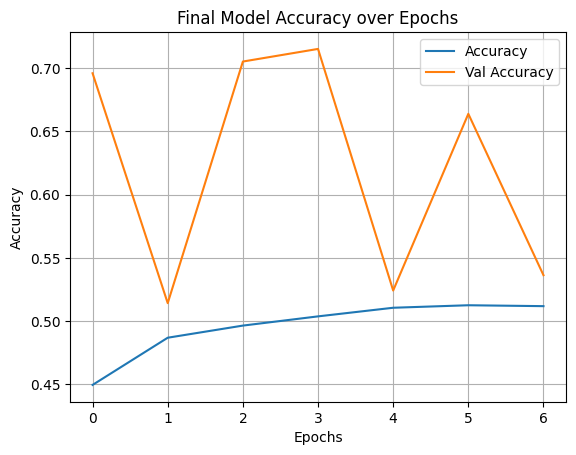

In [42]:
#Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#Plotting loss and validation loss
plt.plot(hist_final_model.history['loss'], label='Loss')
plt.plot(hist_final_model.history['val_loss'],label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Final Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

#Plotting accuracy and validation accuracy
plt.plot(hist_final_model.history['accuracy'], label='Accuracy')
plt.plot(hist_final_model.history['val_accuracy'],label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Final Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# saving the model for testing purposes
final_model.save("trained_MLP.h5")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


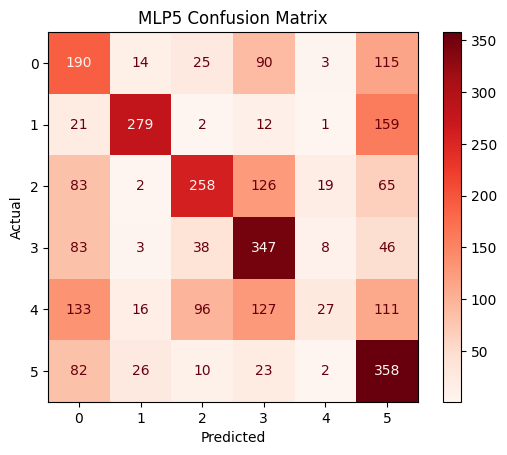

Prediction Shape: (3000,)
Test Shape: (3000,)
Num Samples in Matrix: 3000
Classification Report...
              precision    recall  f1-score   support

   buildings       0.32      0.43      0.37       437
      forest       0.82      0.59      0.69       474
     glacier       0.60      0.47      0.53       553
    mountain       0.48      0.66      0.56       525
         sea       0.45      0.05      0.09       510
      street       0.42      0.71      0.53       501

    accuracy                           0.49      3000
   macro avg       0.52      0.49      0.46      3000
weighted avg       0.52      0.49      0.46      3000

Total Accuracy: 0.48633333333333334


In [43]:
from sklearn.metrics import accuracy_score,classification_report

#get y prediction and class labels
y_pred = final_model.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
classes = list(classes) # same order everywhere

print("Classes:",classes)

#Confusion Matrix
cm = confusion_matrix(ytest, y_pred_classes)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot(cmap='Reds')
plt.title("MLP5 Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Prediction Shape:",y_pred_classes.shape)
print("Test Shape:",ytest.shape)
print("Num Samples in Matrix:",confusion_matrix(ytest,y_pred_classes).sum())

print("Classification Report...")
print(classification_report(ytest,y_pred_classes,target_names=classes))
print("Total Accuracy:",accuracy_score(ytest,y_pred_classes))